This notebook aims to present in the fomr of violin plots the overall distribution of similarity scores. For each group we plot the similarity distrubtion in terms of color, contrast, resnet and dino, with distinction for ai and web inspirations. It takes all scores of the group combined, not scores for each individual final submssion photo

## Imports and loader functions

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import cv2
import numpy as np
import PIL
import os
import re

In [2]:
def imshow(img):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img).convert("RGB"))
    
def imshow_on_axis(img, ax, title):
    img = img.astype(np.uint8)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

            
def load_images_from_path(path, number):
    images = []
    srcs = []
    pattern = rf"^{number}(?!\d)"
    
    for filename in os.listdir(path):
        if re.match(pattern, filename):
            img = cv2.imread(os.path.join(path, filename))
            if img is not None:
                images.append(img)
                srcs.append(filename)

    return images, srcs


def load_images(number):
    final_images = []
    final_srcs = []

    final_path = f"data/final_submissions/{number}/"
    web_path = "data/web/"
    ai_path = "data/ai/"

    if not os.path.exists(final_path):
        print(f"The final submissions path '{final_path}' does not exist.")
        return None, None, None

    for filename in os.listdir(final_path):
        img = cv2.imread(os.path.join(final_path, filename))
        if img is not None:
            final_images.append(img)
            final_srcs.append(f"{number}_{filename}")

    web_images, web_srcs = load_images_from_path(web_path, number)
    ai_images, ai_srcs = load_images_from_path(ai_path, number)

    if not final_images:
        print(f"No images found in '{final_path}'. Please check the contents.")
        return None, None, None

    if not web_images and not ai_images:
        print(
            f"The number '{number}' does not correspond to any valid images in 'web' or 'ai' folders."
        )
        return None, None, None

    if not web_images:
        print(f"No web images found with prefix '{number}' in '{web_path}'.")
        return None, None, None
    if not ai_images:
        print(f"No AI images found with prefix '{number}' in '{ai_path}'.")
        return None, None, None

    return final_images, web_images, ai_images, final_srcs, web_srcs, ai_srcs

In [3]:
def read_csv(path):
    try:
        df = pd.read_csv(path)
        return df
    except Exception as e:
        print(f"Error reading the file: {e}")
        return None

## Render simmilarity csvs


In [4]:
resnets_temp=[]
new_columns = ["Final_Submission", "Inspiration", "Similarity"]

for i in range(1,26):
    resnets_temp.append(read_csv(f"csv/csv2/{i}.csv"))
#Temp fix cause we still dont have all data for 26 group
resnets_temp.append(read_csv(f"csv/csv2/27.csv"))

resnets = pd.concat(resnets_temp, ignore_index=True)
resnets.columns = new_columns
resnets["Final_Submission"] = resnets["Final_Submission"].apply(lambda x: "_".join(x.split('/')[-2:]))
resnets["Inspiration"] = resnets["Inspiration"].apply(lambda x: x.split('/')[-1])


colors = read_csv("csv/color_similarity.csv")

dinos=read_csv("csv/dino_similarity.csv")
dinos.columns = new_columns
dinos["Final_Submission"] = dinos["Final_Submission"].apply(lambda x: "_".join(x.split('\\')[-2:]))
dinos["Inspiration"] = dinos["Inspiration"].apply(lambda x: x.split('\\')[-1])

contrasts = read_csv("csv/contrast_similarity.csv")
contrasts.columns = new_columns
contrasts["Final_Submission"] = contrasts["Final_Submission"].apply(lambda x: "_".join(x.split('\\')[-2:]))
contrasts["Inspiration"] = contrasts["Inspiration"].apply(lambda x: x.split('\\')[-1])

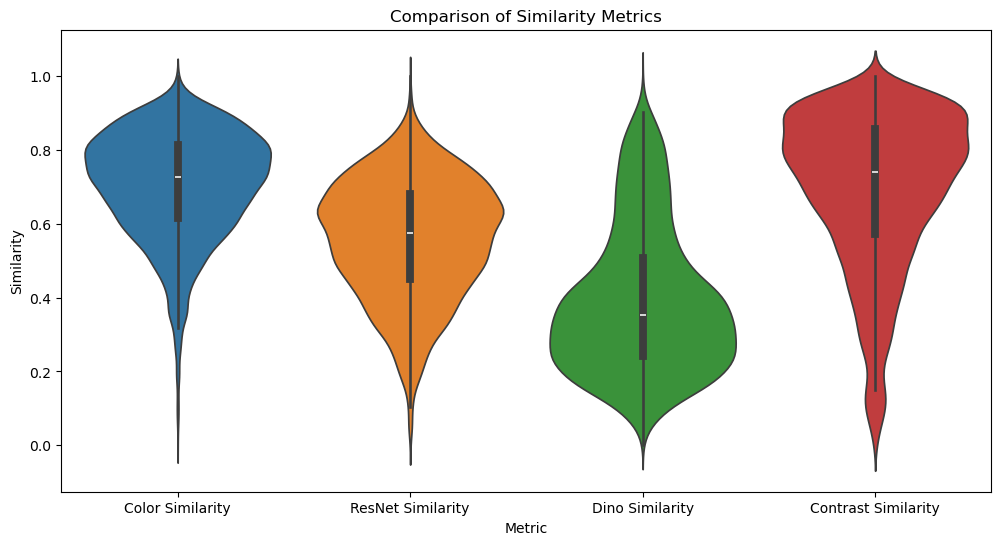

In [5]:
csv_files =[
    colors,
    resnets,
    dinos,
    contrasts
    ]
def zero_one_scale(x:pd.Series):
    return (x-x.min())/(x.max()-x.min())

def standard_scale(x:pd.Series):
    return (x-x.mean())/x.std()


for file in csv_files:
    file["Similarity"] = zero_one_scale(file["Similarity"])
    
metrics = ["Color Similarity", "ResNet Similarity", "Dino Similarity", "Contrast Similarity"]

# Combine each metric into a single DataFrame with a new 'Metric' column
dfs = []
for csv_file, metric in zip(csv_files, metrics):
    df = csv_file.copy()
    df['Metric'] = metric  # Add a column for metric type
    dfs.append(df)

# Concatenate all DataFrames
all_data = pd.concat(dfs, ignore_index=True)

# Plot the violin plot with metric type as hue
#plt.figure(figsize=(7.5, 3*len(csv_files)))
plt.figure(figsize=(3*len(csv_files), 6))
sns.violinplot(data=all_data, x="Metric", y="Similarity", hue="Metric")
plt.title("Comparison of Similarity Metrics")
plt.ylabel("Similarity")
plt.xlabel("Metric")
plt.show()

In [6]:
metrics = ['Color_Similarity', 'ResNet_Similarity', 'Dino_Similarity', 'Contrast_Similarity']

In [7]:
combined_df = read_csv("csv/all_similarities_with_srcs.csv")
combined_df.head()

,Final_Submission,Inspiration,Color_Similarity,ResNet_Similarity,Dino_Similarity,Contrast_Similarity,Source
0,1_1.png,1A_1.jpg,0.529821,0.797856,0.775847,0.744530,Web
1,1_1.png,1A_10.jpg,0.858951,0.604741,0.586041,0.624540,Web
2,1_1.png,1A_2.jpg,0.751328,0.615733,0.303534,0.883636,Web
3,1_1.png,1A_3.jpg,0.720056,0.551096,0.340668,0.869095,Web
4,1_1.png,1A_4.jpg,0.769988,0.652863,0.453489,0.813474,Web


## See sina plots of simmilarities for each group


In [8]:
import scipy.stats as stats
from scipy.stats import norm

def perform_mannwhitneyu_test(data, p=0.05):
    #Test to define wheter distributions of the two groups are equal or not
    #If not equal we assume that the one with higher median is better
    print(f"Results of Mann-Whitney U test on a significance level of {(1-p)*100}%: ")
    for metric in metrics:
        scores_method_1 = data[data['Metric'] == metric].query("Source == 'AI'")['Similarity']
        scores_method_2 = data[data['Metric'] == metric].query("Source == 'Web'")['Similarity']

        statistic, p_value = stats.mannwhitneyu(scores_method_1, scores_method_2, alternative='two-sided')

        if p_value < p:
            if scores_method_1.median() > scores_method_2.median():
                print(f"Mean strength of inspiration from AI is statistically significantly higher than from WEB for metric {metric}.")
            else:
                print(f"Mean strength of inspiration from WEB is statistically significantly higher than from AI for metric {metric}.")
        else:
            print(f"There is no statistically significant difference between the AI and WEB sources of inspiration for metric {metric}.")
    print()

In [9]:
from statsmodels.stats.weightstats import ztest as ztest

def perform_z_test(data, p=0.05):
    # Test to define wheter the mean of two groups are equal or not
    # If not equal we assume that the one with higher mean is better
    print(f"Results of Z-test on a significance level of {(1-p)*100}%:")
    for metric in metrics:
        scores_method_1 = data[data['Metric'] == metric].query("Source == 'AI'")['Similarity']
        scores_method_2 = data[data['Metric'] == metric].query("Source == 'Web'")['Similarity']

        if len(scores_method_1) <= 30 or len(scores_method_2) <= 30:
            print(f"Sample sizes are too small to perform z_test.")
            print()
            return

        statistic, p_value = ztest(scores_method_1, scores_method_2, value = 0, usevar='unequal')

        if p_value < p:
            if scores_method_1.mean() > scores_method_2.mean():
                print(f"Mean strength of inspiration from AI is statistically significantly higher than from WEB for metric {metric}.")

            else:
                print(f"Mean strength of inspiration from WEB is statistically significantly higher than from AI for metric {metric}.")
        else:
            print(f"There is no statistically significant difference between the AI and WEB sources of inspiration for metric {metric}.")
    print()

In [10]:
from scipy.stats import shapiro

def perform_t_test(data, p=0.05):
    #Test to define wheter the mean of two groups are equal or not
    #Can only be performed if the data is normally distributed
    #Check if the data is normally distributed
    print(f"Results of T-test on a significance level of {(1-p)*100}%:")
    for metric in metrics:
        scores_method_1 = data[data['Metric'] == metric].query("Source == 'AI'")['Similarity']
        scores_method_2 = data[data['Metric'] == metric].query("Source == 'Web'")['Similarity']
        
        _, p_value_1 = shapiro(scores_method_1)
        _, p_value_2 = shapiro(scores_method_2)
        
        if p_value_1 > p and p_value_2 > p:
            statistic, p_value = stats.ttest_ind(scores_method_1, scores_method_2, equal_var=False)
            if p_value < p:
                if scores_method_1.mean() > scores_method_2.mean():
                    print(f"Mean strength of inspiration from AI is statistically significantly higher than from WEB for metric {metric}.")
                else:
                    print(f"Mean strength of inspiration from WEB is statistically significantly higher than from AI for metric {metric}.")
            else:
                print(f"There is no statistically significant difference between the AI and WEB sources of inspiration for metric {metric}.")
        else:
            print(f"Data for metric {metric} is not normally distributed. T-test cannot be performed.")
    print() 

In [11]:

def perform_tests_table(data, p=0.05):
    # Perform all tests and print the results in a table
    # As the result we will get the method that is better for each metric
    print(f"Results of statistical tests on a significance level of {(1-p)*100}%:")
    print()
    results = {
        'Metric': metrics,
        'U-test': [],
        'Z-test': [],
        'T-test': []
    }
    
    for metric in metrics:
        scores_method_1 = data[data['Metric'] == metric].query("Source == 'AI'")['Similarity']
        scores_method_2 = data[data['Metric'] == metric].query("Source == 'Web'")['Similarity']
        
        u_statistic, u_p_value = stats.mannwhitneyu(scores_method_1, scores_method_2, alternative='two-sided')
        if u_p_value < p:
            if scores_method_1.median() > scores_method_2.median():
                u_result = "AI"
            else:
                u_result = "WEB"
        else:
            u_result = "none"
            
        if len(scores_method_1) <= 30 or len(scores_method_2) <= 30:
            z_result = "small sample"
        else:
            z_statistic, z_p_value = ztest(scores_method_1, scores_method_2, value = 0, usevar='unequal')
            if z_p_value < p:
                if scores_method_1.mean() > scores_method_2.mean():
                    z_result = "AI"
                else:
                    z_result = "WEB"
            else:
                z_result = "none"
        
        _, s_p_value_1 = shapiro(scores_method_1)
        _, s_p_value_2 = shapiro(scores_method_2)
        
        if s_p_value_1 > p and s_p_value_2 > p:
            t_statistic, t_p_value = stats.ttest_ind(scores_method_1, scores_method_2, equal_var=False)
            if t_p_value < p:
                if scores_method_1.mean() > scores_method_2.mean():
                    t_result = "AI"
                else:
                    t_result = "WEB"
            else:
                t_result = "none"
        else:
            t_result = "not normal"
        
        results['U-test'].append(u_result)
        results['Z-test'].append(z_result)
        results['T-test'].append(t_result)
        
    results_df = pd.DataFrame(results)
    results_df.set_index('Metric', inplace=True)
    transposed_results = results_df.transpose()
    print(transposed_results)
    
    

In [ ]:
def show_simmilarity(group_id, top_count=5):
    filtered_df = combined_df[
        combined_df["Final_Submission"].str.startswith(f"{group_id}_")
    ]

    metrics = [
        "Color_Similarity",
        "ResNet_Similarity",
        "Dino_Similarity",
        "Contrast_Similarity",
    ]
    combined_df_melted = pd.melt(
        filtered_df,
        id_vars=["Final_Submission", "Source"],
        value_vars=metrics,
        var_name="Metric",
        value_name="Similarity",
    )

    combined_df_melted["Metric"] = pd.Categorical(
        combined_df_melted["Metric"], categories=metrics, ordered=True
    )

    top_similarities = (
        combined_df_melted.sort_values(
            ["Final_Submission", "Metric", "Source", "Similarity"],
            ascending=[True, True, False, False],
        )
        .groupby(["Final_Submission", "Metric", "Source"], observed=True)
        .head(top_count)
    )

    custom_palette = {"AI": "#1E74C3", "Web": "#D85C56"}
    strip_palette = {"AI": "#0F4A8E", "Web": "#9A1E1A"}

    plt.figure(figsize=(10, 6))

    sns.violinplot(
        x="Metric",
        y="Similarity",
        hue="Source",
        data=top_similarities,
        inner=None,
        linewidth=1.5,
        split=True,
        palette=custom_palette,
        alpha=0.75,
        edgecolor="black",
    )

    sns.stripplot(
        x="Metric",
        y="Similarity",
        hue="Source",
        data=top_similarities,
        palette=strip_palette,
        jitter=True,
        alpha=0.8,
        size=5,
        dodge=True,
    )

    plt.suptitle(f"GROUP: {group_id}", fontsize=18, fontweight="bold")
    plt.title(f"Top {top_count} most similar inspirations", fontsize=14)
    plt.xlabel("Metric", fontsize=14, fontweight="bold")
    plt.ylabel("Similarity", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

    return top_similarities

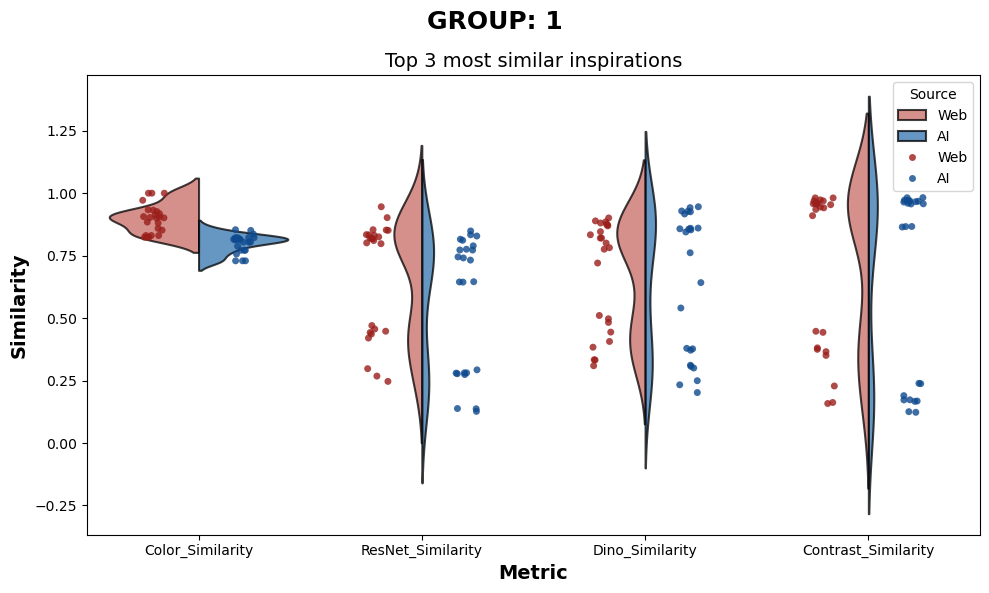

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test              WEB        not normal      not normal          not normal


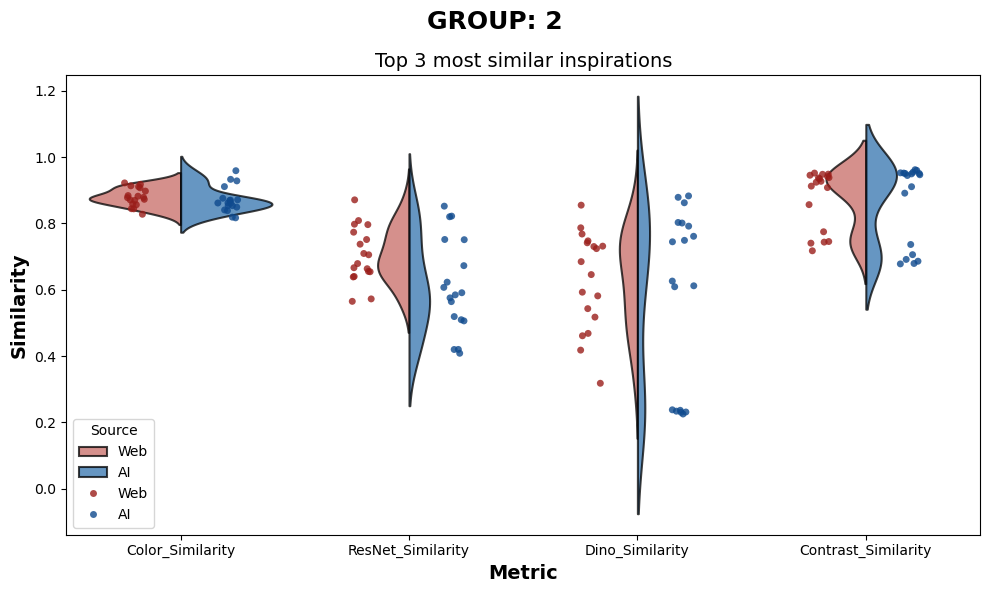

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test             none              none      not normal          not normal


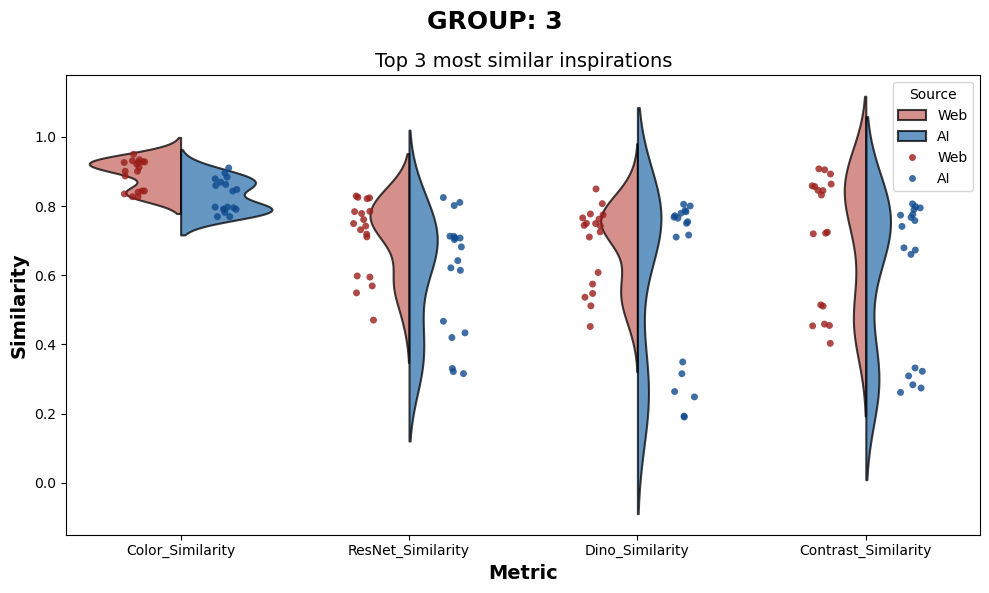

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test       not normal              none      not normal          not normal


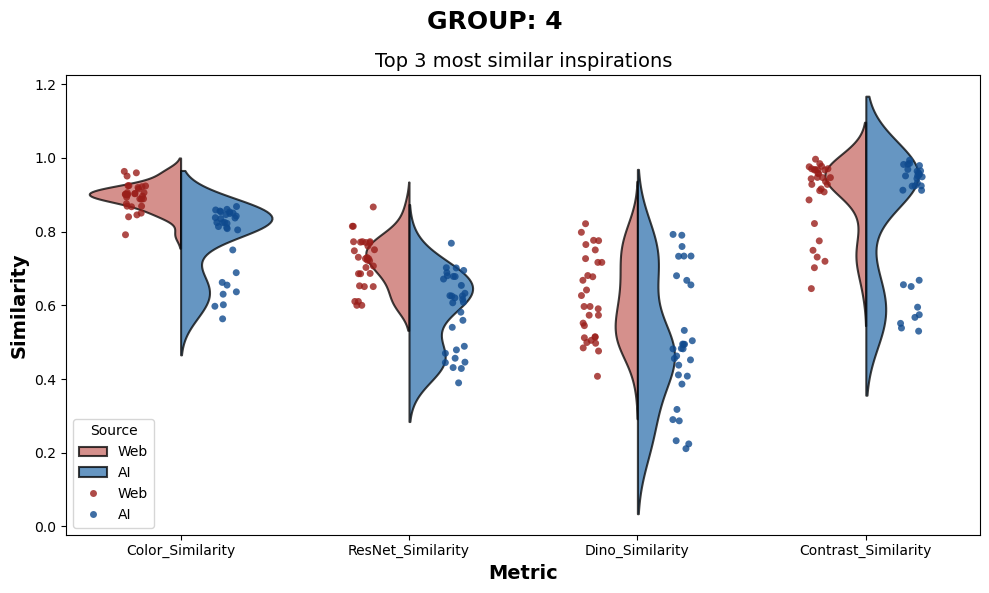

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB             WEB                none
Z-test     small sample      small sample    small sample        small sample
T-test       not normal               WEB             WEB          not normal


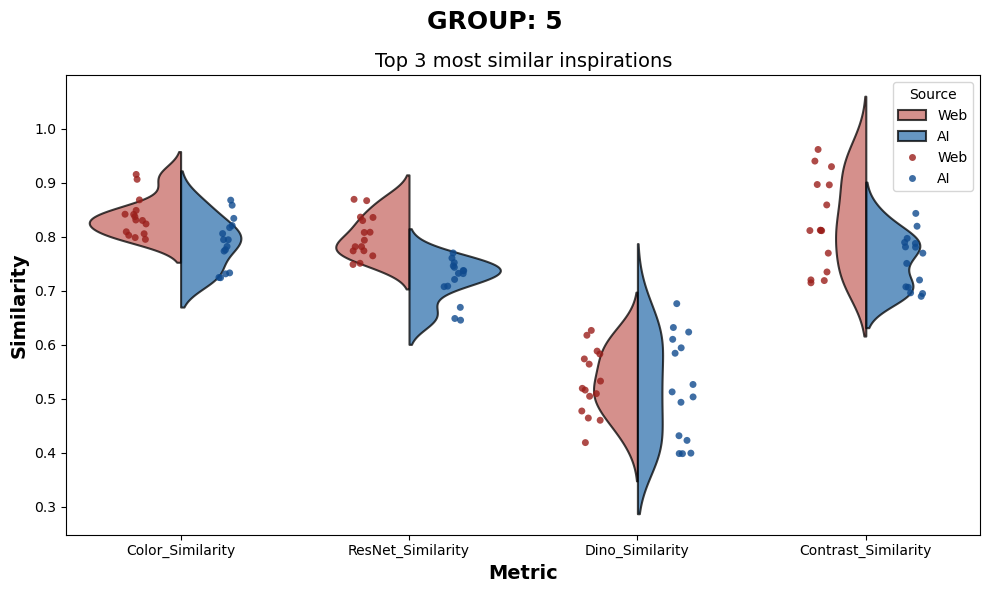

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test     small sample      small sample    small sample        small sample
T-test              WEB               WEB            none                none


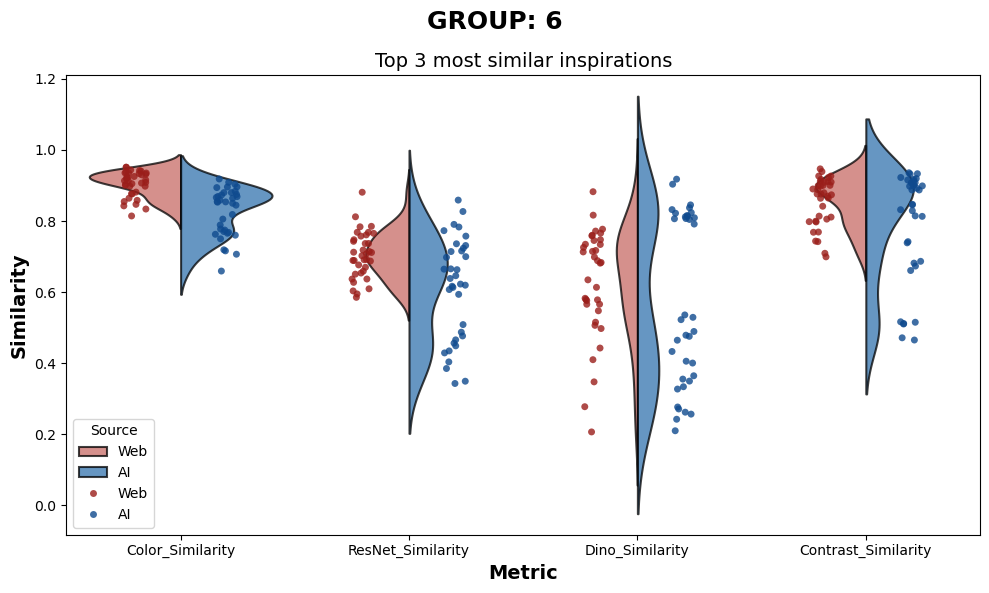

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test              WEB               WEB            none                none
T-test              WEB               WEB      not normal          not normal


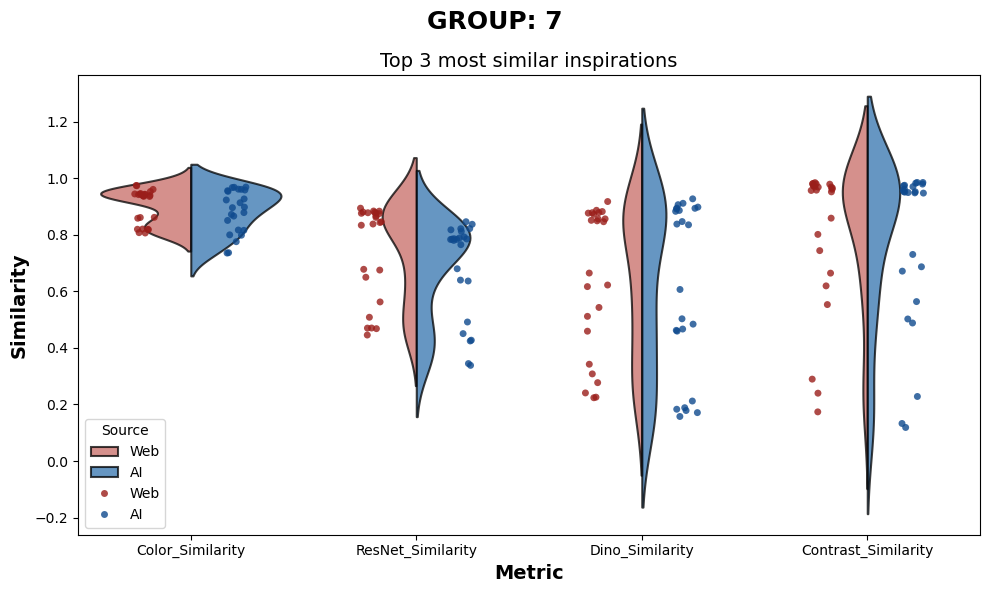

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test       not normal        not normal      not normal          not normal


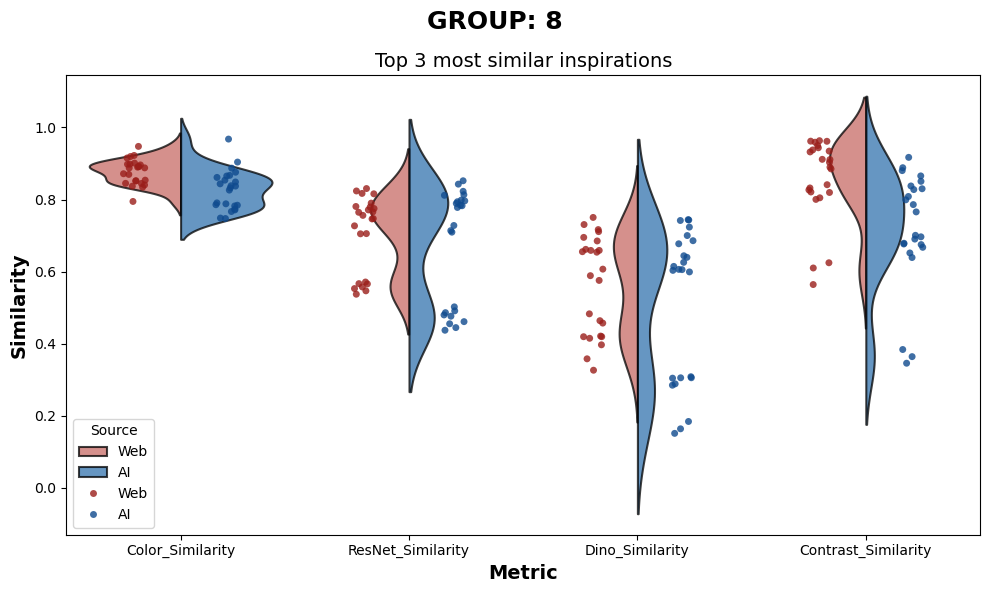

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB              none            none                 WEB
Z-test     small sample      small sample    small sample        small sample
T-test              WEB        not normal      not normal          not normal


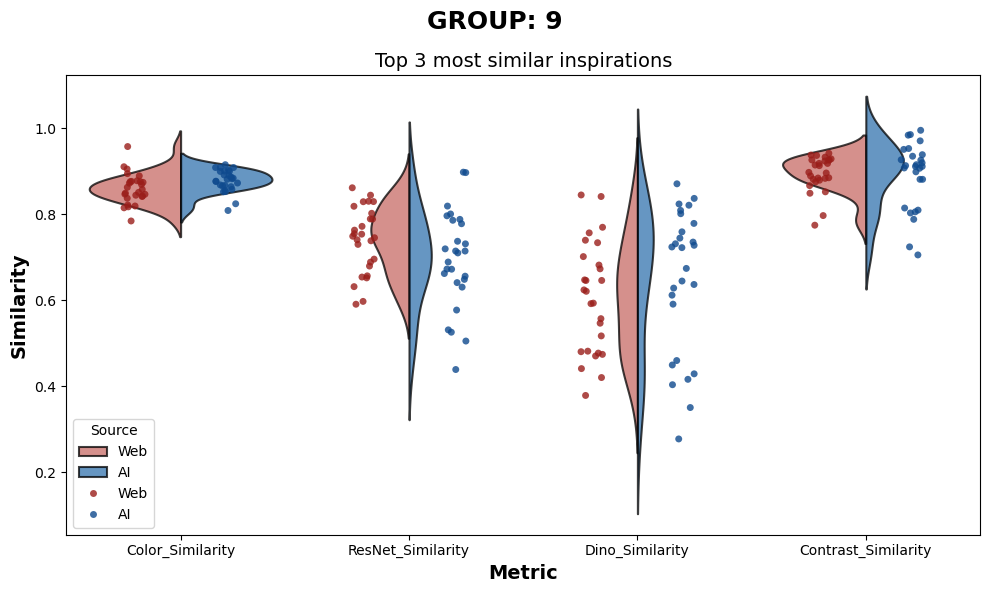

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test             none              none            none          not normal


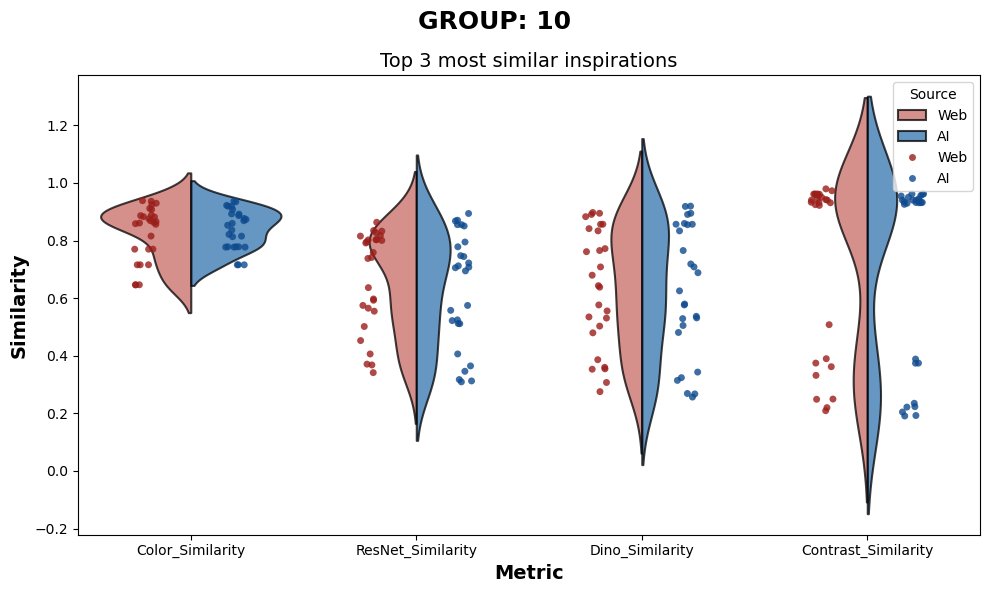

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test       not normal        not normal            none          not normal


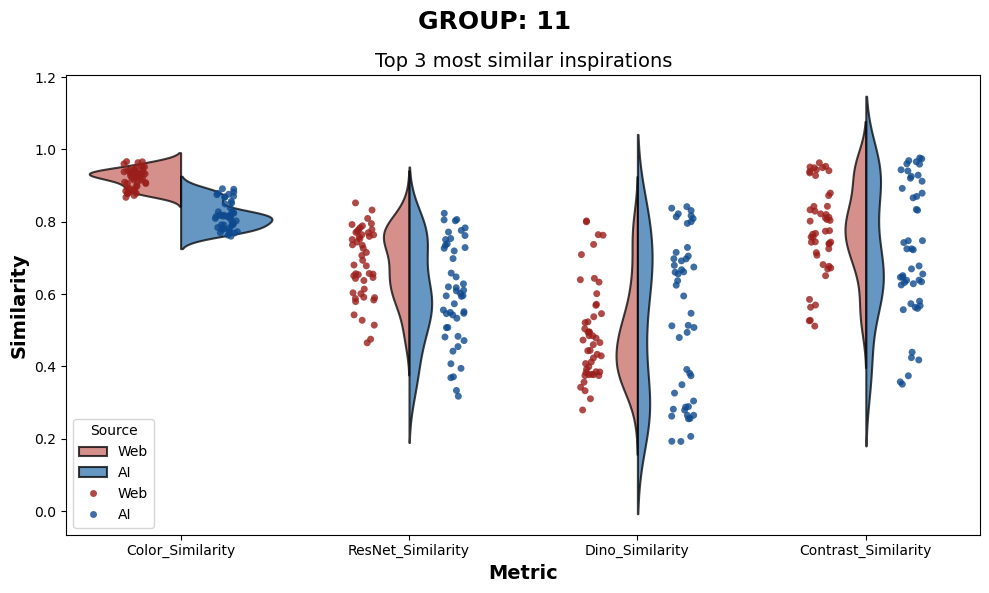

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test              WEB               WEB            none                none
T-test              WEB               WEB      not normal          not normal


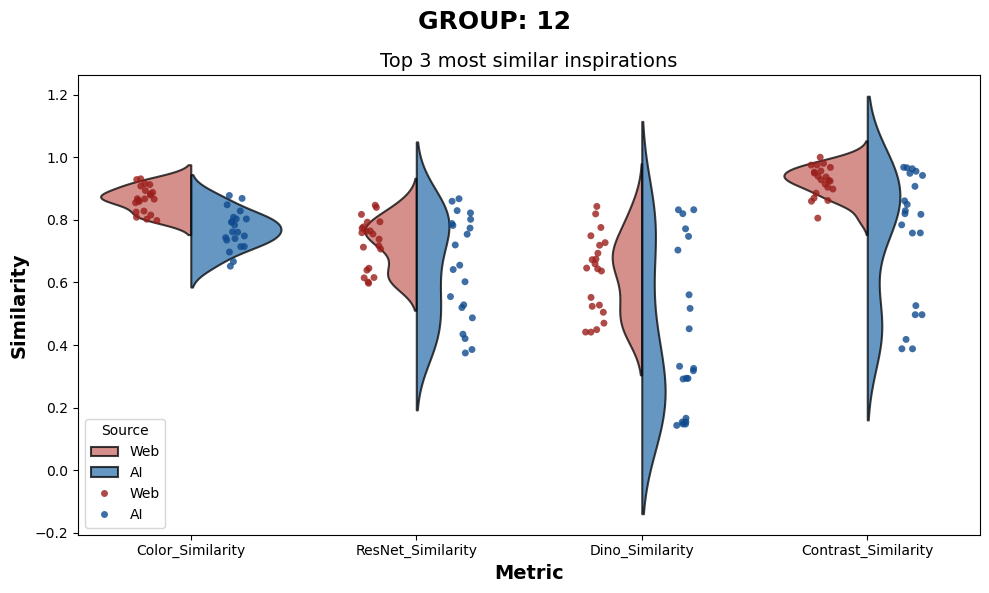

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB              none            none                 WEB
Z-test     small sample      small sample    small sample        small sample
T-test              WEB              none      not normal          not normal


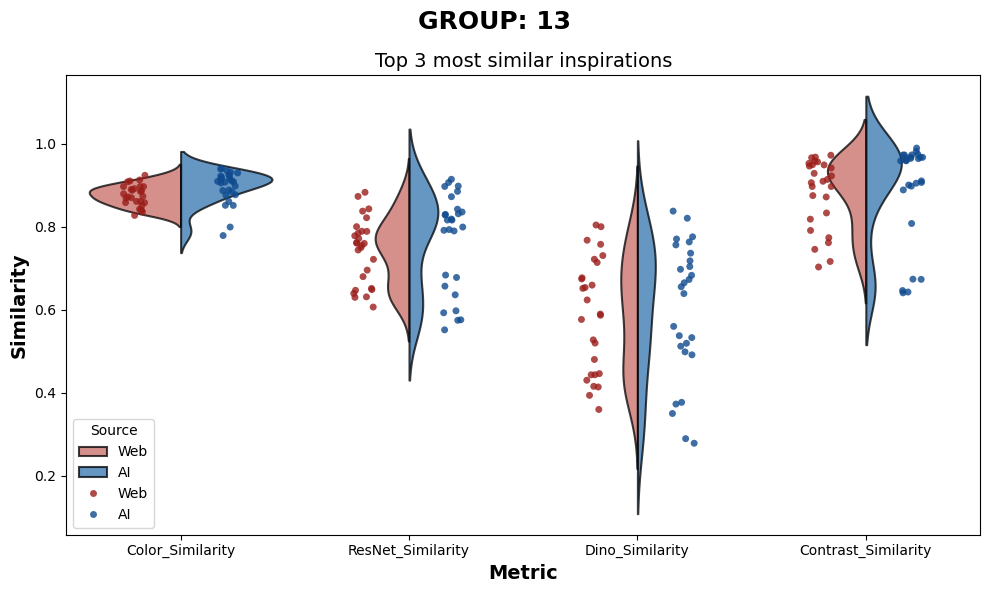

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test               AI              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test       not normal        not normal            none          not normal


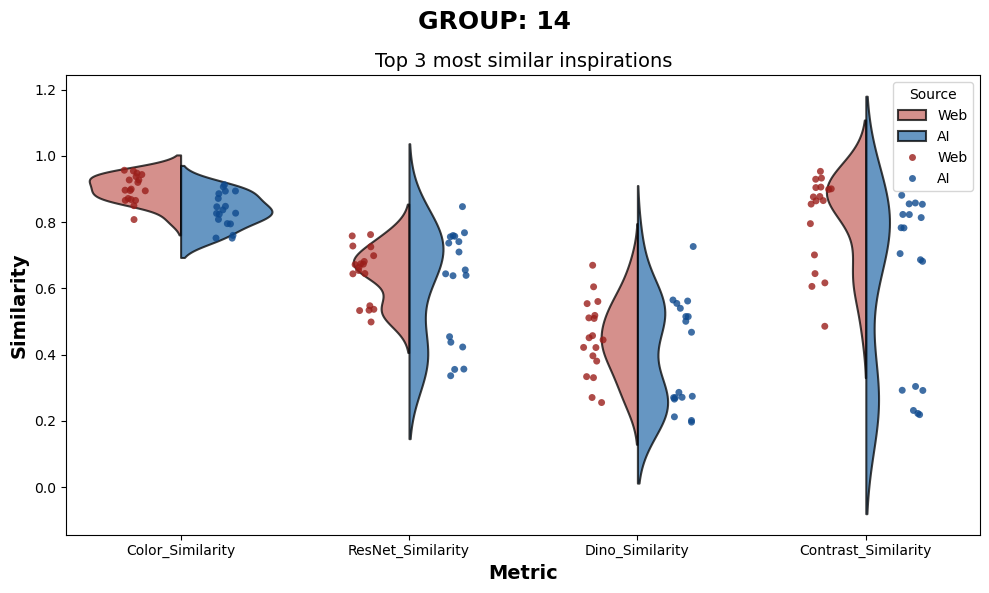

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB              none            none                 WEB
Z-test     small sample      small sample    small sample        small sample
T-test              WEB              none            none          not normal


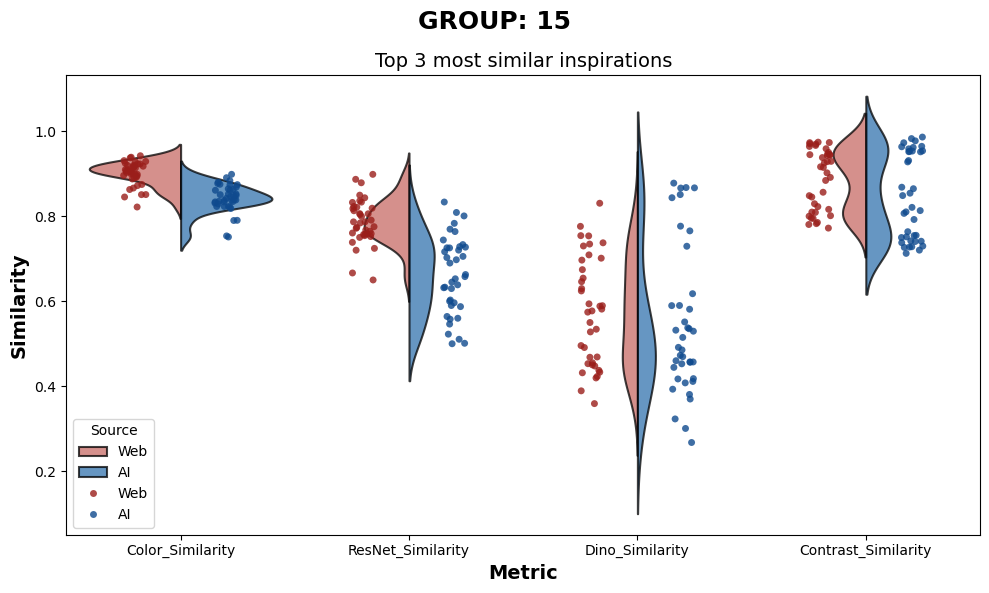

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test              WEB               WEB            none                none
T-test              WEB               WEB      not normal          not normal


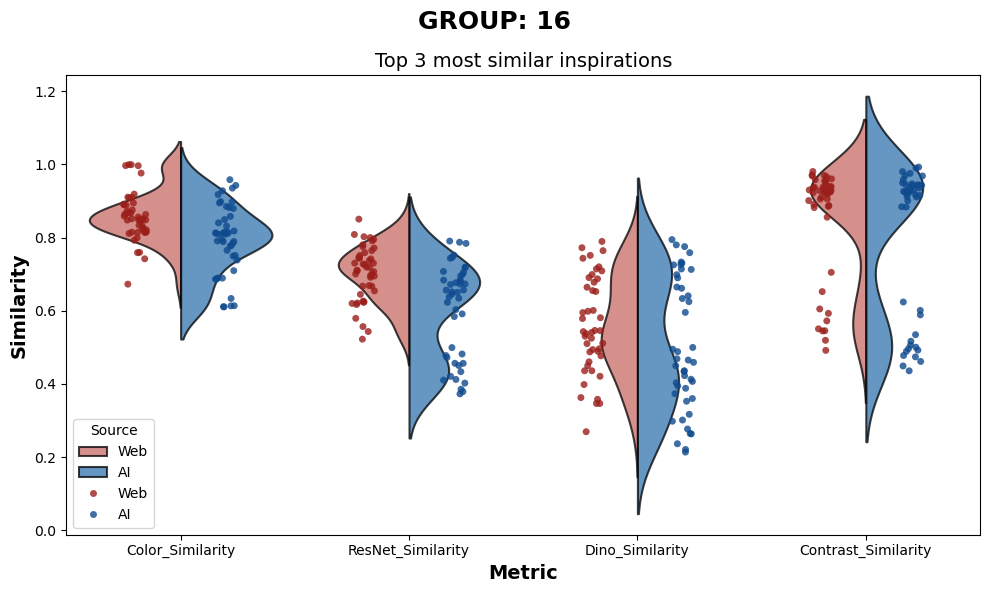

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test              WEB               WEB            none                none
T-test              WEB        not normal      not normal          not normal


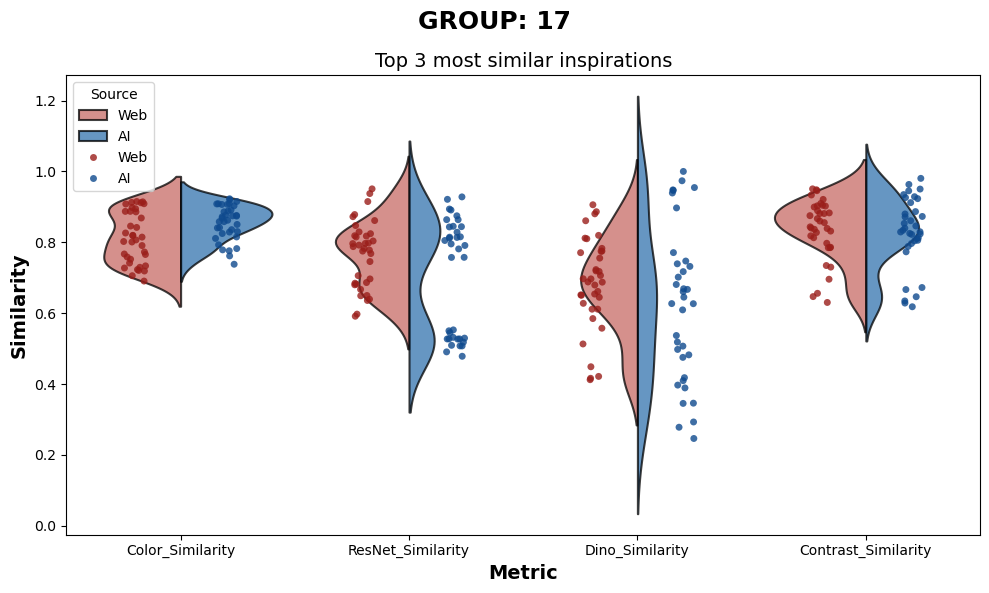

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test               AI              none            none                none
T-test               AI        not normal            none          not normal


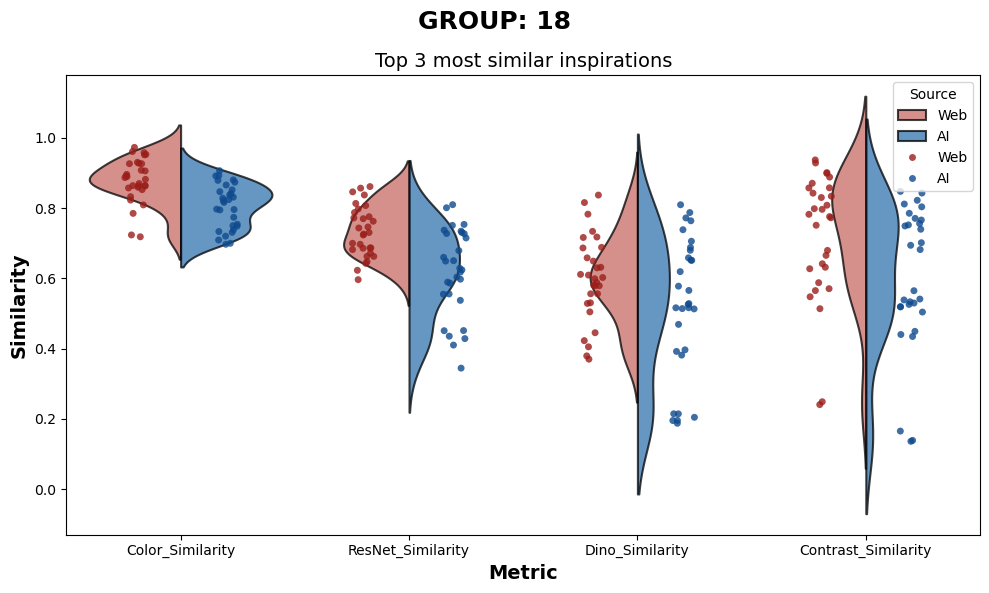

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                 WEB
Z-test     small sample      small sample    small sample        small sample
T-test              WEB               WEB            none          not normal


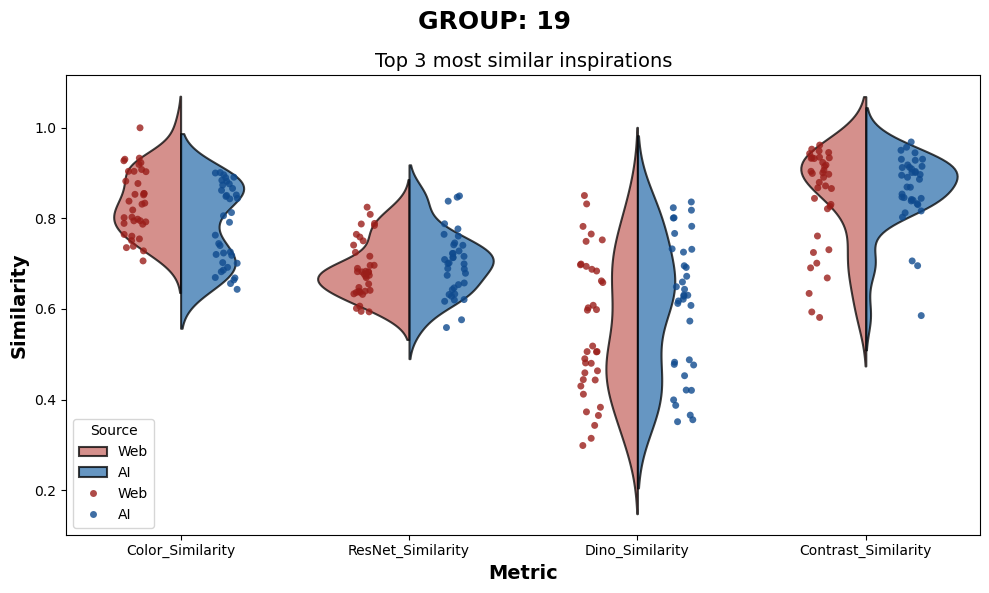

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test              WEB              none            none                none
T-test       not normal              none            none          not normal


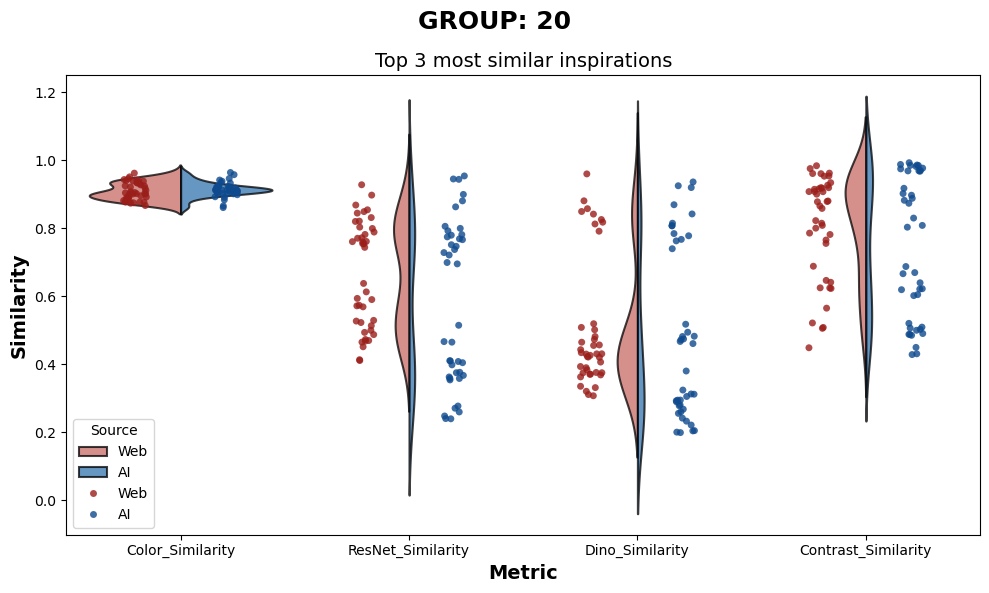

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test             none              none            none                none
T-test             none        not normal      not normal          not normal


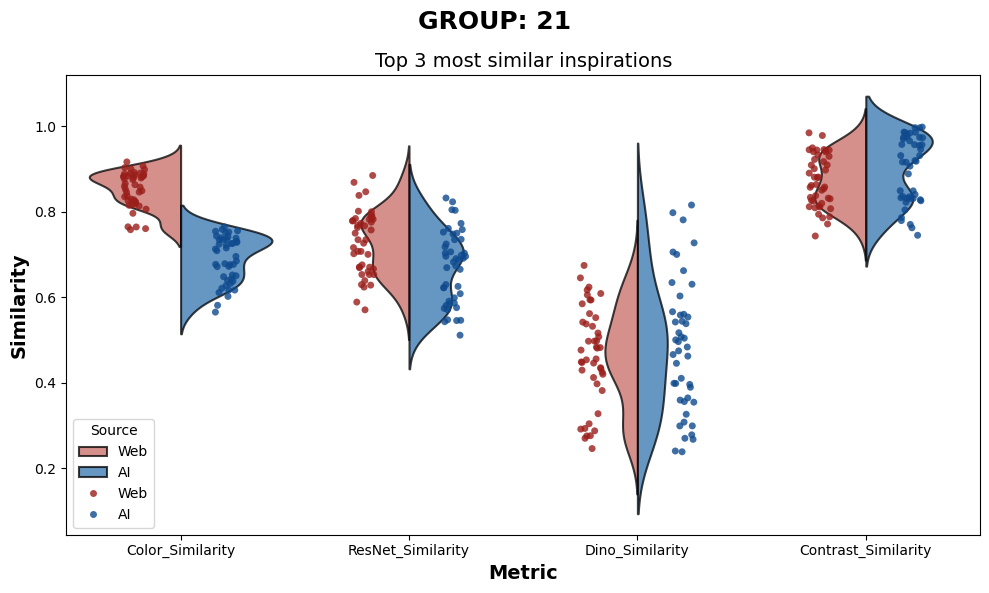

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test              WEB               WEB            none                none
T-test       not normal               WEB            none          not normal


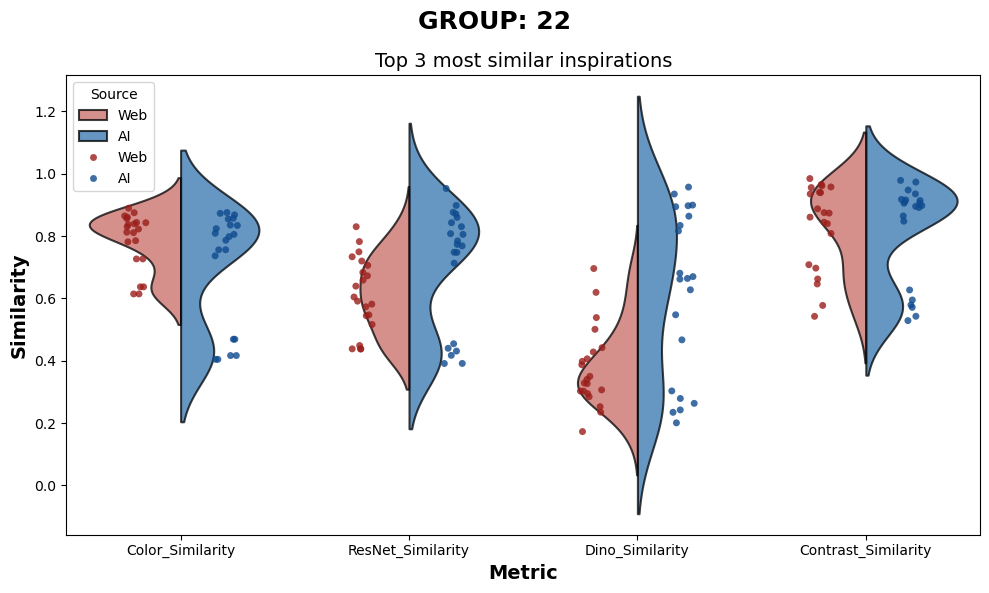

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test       not normal        not normal              AI          not normal


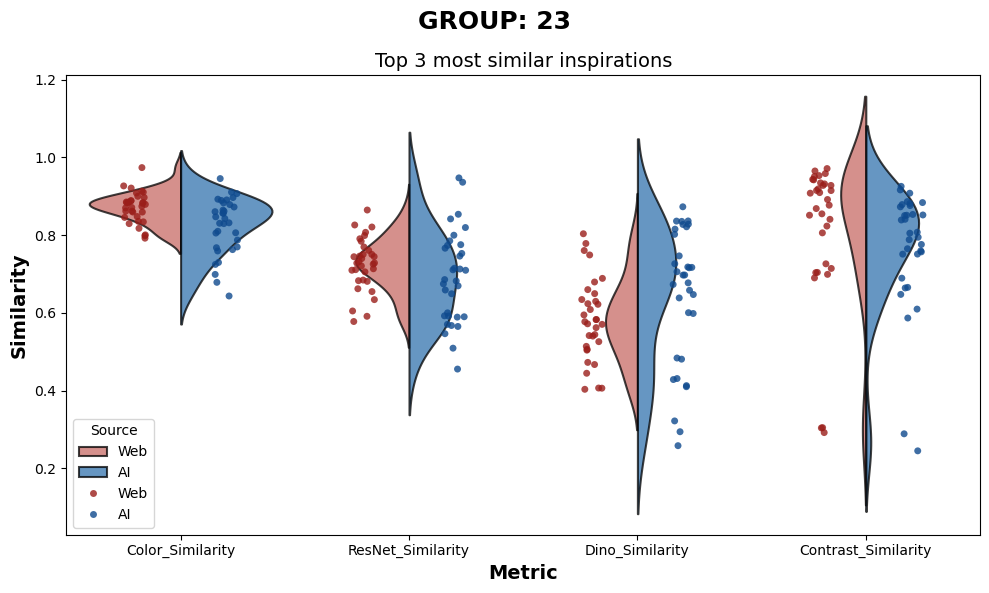

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB              none            none                 WEB
Z-test              WEB              none            none                none
T-test              WEB              none      not normal          not normal


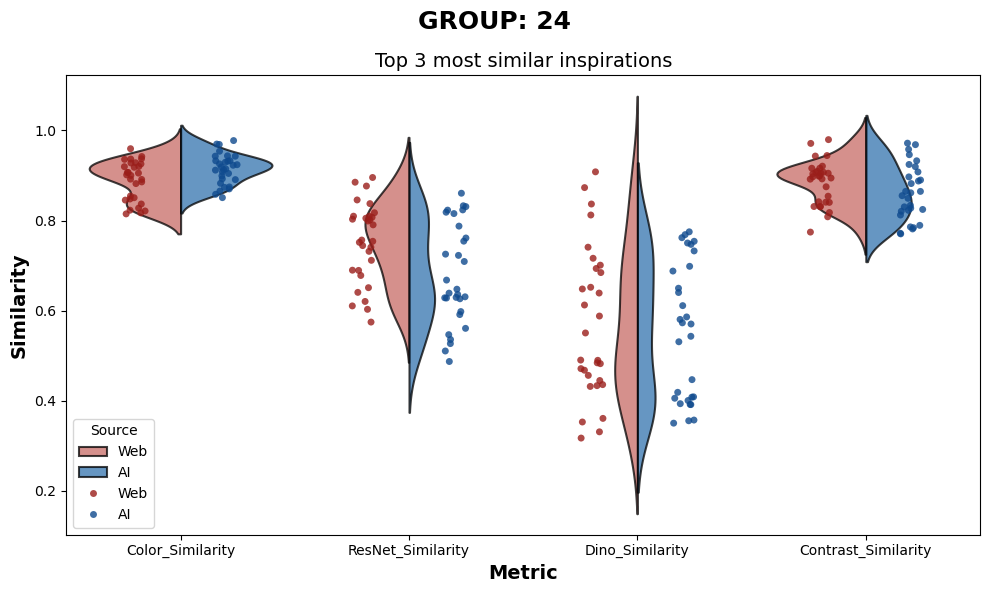

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test     small sample      small sample    small sample        small sample
T-test             none               WEB      not normal                none


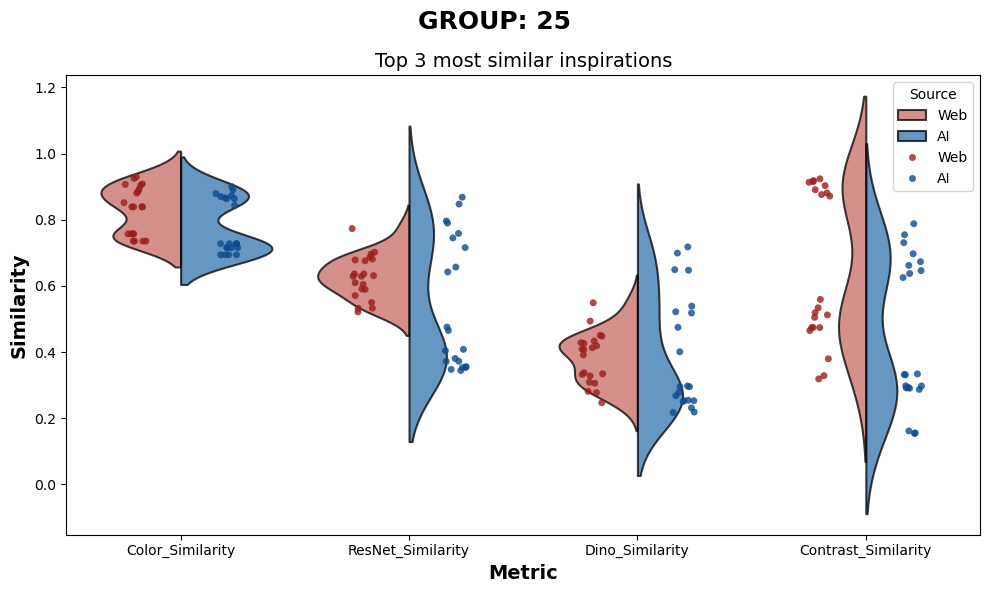

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                 WEB
Z-test     small sample      small sample    small sample        small sample
T-test       not normal        not normal      not normal          not normal


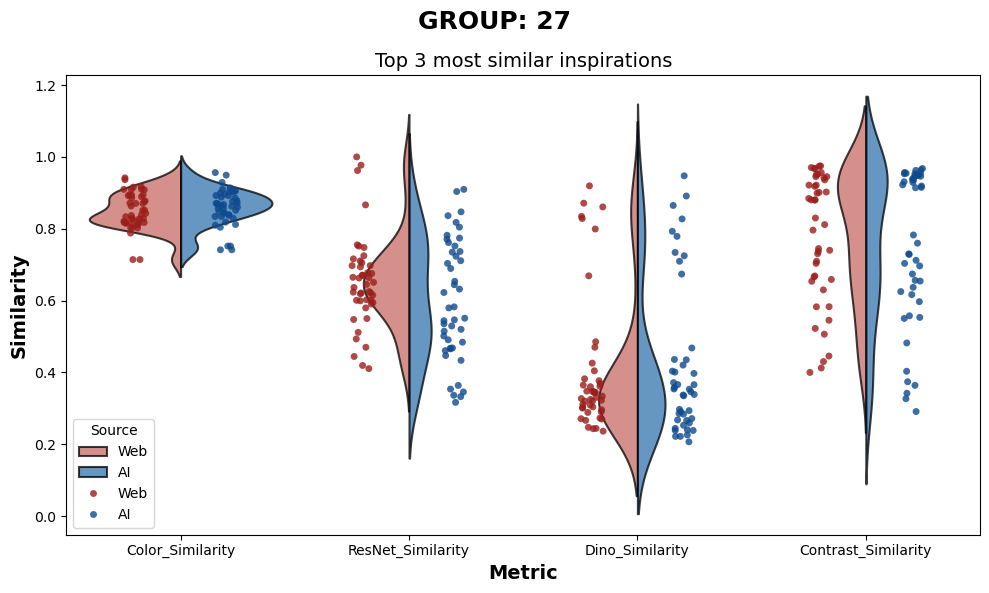

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test             none              none            none                none
Z-test             none              none            none                none
T-test             none        not normal      not normal          not normal


In [13]:
for i in range(1, 26):
    data = show_simmilarity(i, 3)

    perform_tests_table(data, 0.01)

data = show_simmilarity(27, 3)
perform_tests_table(data, 0.01)

## Curiosity: correlation of source of inspiartion and its "strength"

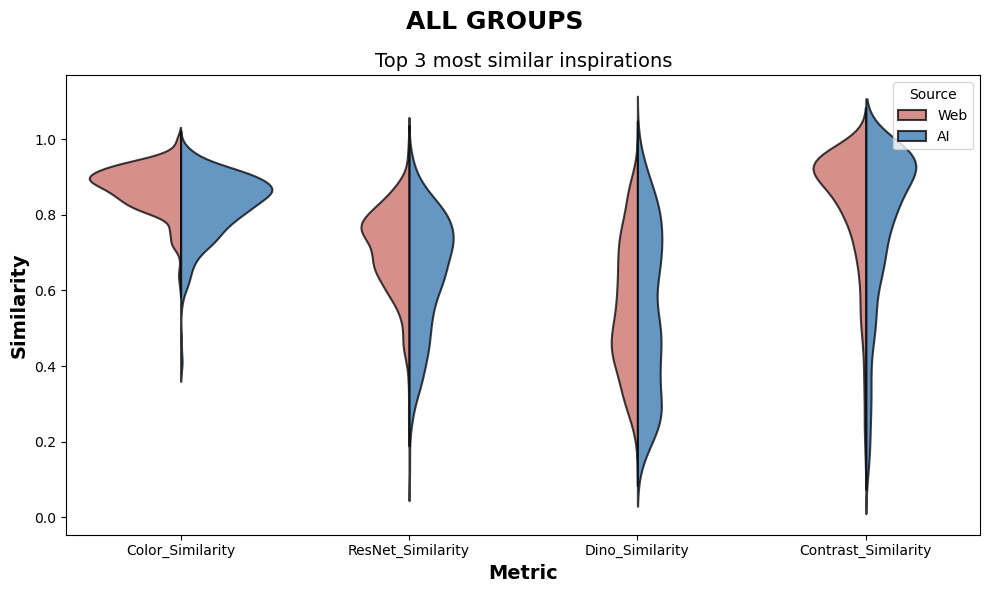

Results of statistical tests on a significance level of 99.99%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                none
Z-test              WEB               WEB            none                 WEB
T-test       not normal        not normal      not normal          not normal


In [16]:
def show_similarity_all_groups(top_count=5):

    metrics = ['Color_Similarity', 'ResNet_Similarity', 'Dino_Similarity', 'Contrast_Similarity']
    combined_df_melted = pd.melt(
            combined_df,
            id_vars=['Final_Submission', 'Source'],
            value_vars=metrics,
            var_name='Metric',
            value_name='Similarity'
        )

    combined_df_melted['Metric'] = pd.Categorical(combined_df_melted['Metric'], categories=metrics, ordered=True)

    top_similarities = (combined_df_melted
                        .sort_values(['Final_Submission', 'Metric', 'Source', 'Similarity'], ascending=[True, True, False, False])
                        .groupby(['Final_Submission', 'Metric', 'Source'], observed=True)
                        .head(top_count))

    custom_palette = {'AI': '#1E74C3', 'Web': '#D85C56'}   

    plt.figure(figsize=(10, 6))

    sns.violinplot(x="Metric", y="Similarity", hue="Source", data=top_similarities, 
                   inner=None, linewidth=1.5, split=True, palette=custom_palette, alpha=0.75,
                   edgecolor='black')  


    plt.suptitle(f'ALL GROUPS', fontsize=18, fontweight='bold')
    plt.title(f'Top {top_count} most similar inspirations', fontsize=14)
    plt.xlabel('Metric', fontsize=14, fontweight='bold')
    plt.ylabel('Similarity', fontsize=14, fontweight='bold')
    plt.tight_layout()  
    plt.show()
    
    return top_similarities

all_groups = show_similarity_all_groups(3)
perform_tests_table(all_groups, 0.0001)

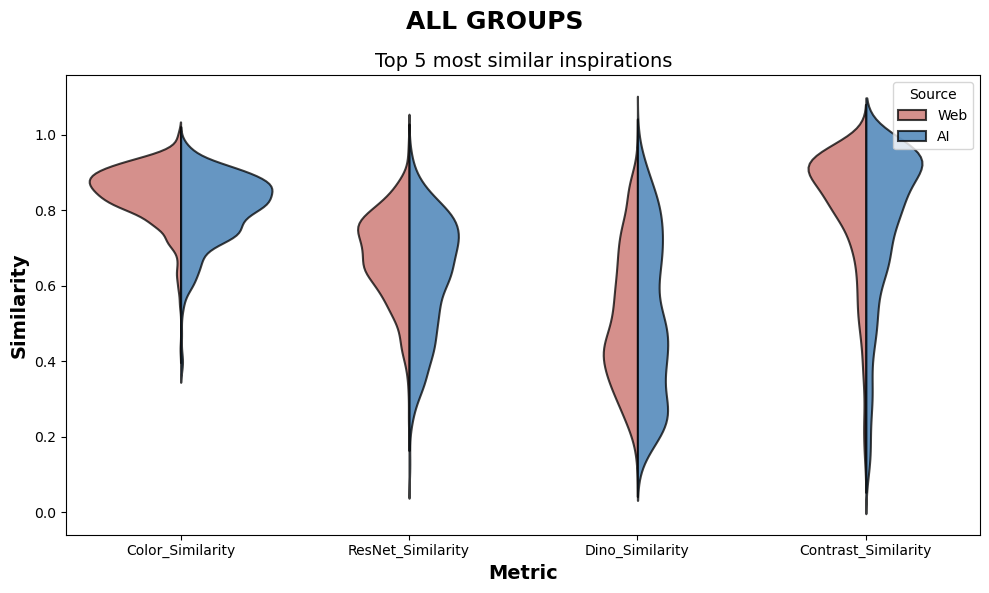

Results of statistical tests on a significance level of 99.0%:

Metric Color_Similarity ResNet_Similarity Dino_Similarity Contrast_Similarity
U-test              WEB               WEB            none                 WEB
Z-test              WEB               WEB            none                 WEB
T-test       not normal        not normal      not normal          not normal


In [15]:
all_groups_more = show_similarity_all_groups(5)
perform_tests_table(all_groups_more, 0.01)